In [1]:
# import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import h5py
import napari
import tifffile as tiff
import seaborn as sns
import pickle

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")
 
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
data_dir_ori = Path(r'Y:\coskun-lab\Thomas\15_PLA\data')
data_dir = data_dir = (Path().cwd().parents[0] / 'data').absolute()

# Get image dataframe 
df_imgs_path = data_dir_ori / '9PPI Cell Culture' / 'Whole' / 'metadata' / 'imgs_reg_norm.csv'
df_imgs = pd.read_csv(df_imgs_path)


In [5]:
# for row in df_imgs.itertuples():
#     path = row.Path
#     # Read markers name 
#     with h5py.File(path, "r") as f:
#         markers = f['imgs'].attrs['Marker']
#         imgs= f['imgs'][:]
#     break


In [6]:
# import napari

# viewer = napari.view_image(imgs, channel_axis=0, name=markers, visible=False, contrast_limits=[0,1])

# PLA quantification

In [ ]:
import PLA

PPI_save_path =  data_dir / '9PPI'  / 'PPI'
PPI_save_path.mkdir(parents=True, exist_ok=True)

PPI_imgs_path =  data_dir / '9PPI'  / 'PPI_imgs'
PPI_imgs_path.mkdir(parents=True, exist_ok=True)

In [14]:
for row in df_imgs.itertuples():
    path = row.Path
    with h5py.File(path, 'r') as f:
        markers = f['imgs'].attrs['Marker']
    print(markers)
    break


['Hoeschst' 'Cyclin D1 & CDK2' 'NF-Kb & p-P90rsk' 'Hoeschst' 'Sox2 & Oct4'
 'Bim & Tom20' 'Hoeschst' 'Mcl-1 & BAK' 'Hoeschst' 'p-ERK & c-MYC'
 'Hoeschst' 'TEAD1 & YAP' 'Hoeschst' 'Cyclin E & CDK4' 'Hoeschst'
 'P-AKT & mTOR' 'Hoeschst' 'p-EGFR' 'Phalloidin' 'Ki67' 'Hoeschst'
 'Cyclin D1 & CDK2 - re' 'NF-Kb & p-P90rsk - re' 'Hoeschst' 'NBD-C6'
 'Golph4' 'COX IV' 'Hoeschst' 'Pan-cytokeratin' 'Hoeschst'
 'Concanavalin A' 'WGA']


In [15]:
PPI_markers = ['Cyclin D1 & CDK2', 'NF-Kb & p-P90rsk', 'Sox2 & Oct4',
 'Bim & Tom20', 'Mcl-1 & BAK', 'p-ERK & c-MYC',
'TEAD1 & YAP', 'Cyclin E & CDK4', 'P-AKT & mTOR', 'Cyclin D1 & CDK2 - re', 'NF-Kb & p-P90rsk - re']

In [16]:
for row in df_imgs.itertuples():
    # Read image
    path = row.Path
    pla_detect = PLA.PLA_detection(path, name='imgs', m='Marker')
    
    with h5py.File(path, 'r') as f:
        markers = f['imgs'].attrs['Marker']
        
    imgs_spots = []
    imgs_wths = []
    imgs_raw = []
    for RNA in PPI_markers: 
        if RNA in markers:
            img_spot, img_wth, _, img = pla_detect.detect_spot(RNA, thres=0.03, min_radius=2)
            imgs_spots.append(img_spot)
            imgs_wths.append(img_wth)
            imgs_raw.append(img)
            
     # Save imgs
    file_path = PPI_imgs_path / ('_'.join(row[1:3]) + '_raw.tiff')
    tiff.imwrite(file_path, imgs_raw)
    file_path = PPI_imgs_path / ('_'.join(row[1:3]) + '_processed.tiff')
    tiff.imwrite(file_path, imgs_wths)
    file_path = PPI_imgs_path / ('_'.join(row[1:3]) + '_detected.tiff')
    tiff.imwrite(file_path, imgs_spots)

    # Save PPI dict
    name = '_'.join(row[1:3]) +'.pkl'
    pla_detect.save_pickle(PPI_save_path / name)

Reading image Cyclin D1 & CDK2
Processing image Cyclin D1 & CDK2
(array([0, 1], dtype=uint8), array([28214997,  1396529], dtype=int64))
Reading image NF-Kb & p-P90rsk
Processing image NF-Kb & p-P90rsk
(array([0, 1], dtype=uint8), array([29269448,   342078], dtype=int64))
Reading image Sox2 & Oct4
Processing image Sox2 & Oct4
(array([0, 1], dtype=uint8), array([29224135,   387391], dtype=int64))
Reading image Bim & Tom20
Processing image Bim & Tom20
(array([0, 1], dtype=uint8), array([29381105,   230421], dtype=int64))
Reading image Mcl-1 & BAK
Processing image Mcl-1 & BAK
(array([0, 1], dtype=uint8), array([29597919,    13607], dtype=int64))
Reading image p-ERK & c-MYC
Processing image p-ERK & c-MYC
(array([0, 1], dtype=uint8), array([29496378,   115148], dtype=int64))
Reading image TEAD1 & YAP
Processing image TEAD1 & YAP
(array([0, 1], dtype=uint8), array([29602586,     8940], dtype=int64))
Reading image Cyclin E & CDK4
Processing image Cyclin E & CDK4
(array([0, 1], dtype=uint8), ar

In [17]:
# import napari

# viewer = napari.view_image(np.stack(imgs_wths))
# viewer.add_image(np.stack(imgs_raw))
# viewer.add_image(np.stack(imgs_spots), contrast_limits=[0,1], blending='additive')

# Extract per cell PPI count

In [7]:
import pickle 

def read_PPI(path):
    with open(path, 'rb') as file:
        PPI_dict = pickle.load(file)

    return PPI_dict

def create_PPI_df(PPI_labels, PPI_loc, name, cyto=True):
    if cyto:
        columns_name = ['Cyto', 'x', 'y']
    else:
        columns_name = ['Nuclei', 'x', 'y']
    df = pd.DataFrame(np.hstack([PPI_labels[:,np.newaxis], PPI_loc]), 
                      columns=columns_name)
    df['PPI'] = name
    return df

In [8]:
mask_filt_dir = Path(r'Y:\coskun-lab\Thomas\15_PLA\data\9PPI Cell Culture\Whole\imgs\masks_filtered')
PPI_save_path =  data_dir / '9PPI'  / 'PPI'

masks_path = defaultdict(dict) 
for path in os.listdir(mask_filt_dir):
    name = path.split('.')[0]
    if 'Nuclei' in name:
        masks_path[name[7:]]['nuclei'] = mask_filt_dir / path
    elif 'Cyto' in name:
        masks_path[name[5:]]['cyto'] =mask_filt_dir / path
    elif 'Cell' in name:
        masks_path[name[5:]]['cell'] =mask_filt_dir / path    
    elif 'df' in name:
        masks_path[name[3:]]['df'] =mask_filt_dir / path
    else:
        pass

In [9]:
for row in df_imgs.itertuples():
    name = '_'.join(row[1:3])
    
    # Read masks
    mask_cyto_path = masks_path[name]['cell']
    mask_nuclei_path = masks_path[name]['nuclei']
    df_path =  masks_path[name]['df']
    
    mask_cyto = skimage.io.imread(mask_cyto_path)
    mask_nuclei = skimage.io.imread(mask_nuclei_path)
    df_cell_info = pd.read_csv(df_path)
    nuclei2cell = dict(zip(df_cell_info.iloc[:,0], df_cell_info.iloc[:,1]))   
    
    # Read PPi
    PPI_dict = read_PPI(PPI_save_path / f'{name}.pkl')
    dfs_PPI_cyto = []
    dfs_PPI_nuclei = []
    for k in PPI_dict.keys():
        PPI_loc = PPI_dict[k][:, 1:3].astype(np.uint32)
        
        # Cyto
        PPI_labels = mask_cyto[PPI_loc[:,0], PPI_loc[:,1]]
        df_PPI = create_PPI_df(PPI_labels, PPI_loc, k)
        dfs_PPI_cyto.append(df_PPI)
        
        # Nuclei
        PPI_labels = mask_nuclei[PPI_loc[:,0], PPI_loc[:,1]]
        df_PPI = create_PPI_df(PPI_labels, PPI_loc, k, cyto=False)
        dfs_PPI_nuclei.append(df_PPI)
    
    # Combined DFs
    df_PPI_cyto = pd.concat(dfs_PPI_cyto)
    df_PPI_nuclei = pd.concat(dfs_PPI_nuclei)
    df_PPI_nuclei['Nuclei_Cell'] = df_PPI_nuclei['Nuclei'].apply(lambda x: nuclei2cell.get(x,x))   
    df_merged = df_PPI_cyto.merge(df_PPI_nuclei)
    df_merged['Condition'] = row[1]
    df_merged['FOV'] = row[2]
    
    # Save dataframe
    path = PPI_save_path / f'{name}.csv'
    df_merged.to_csv(path, index=False)

# Quantification 9PPI

## Statistical plot

In [7]:
# Read PPI
PPI_save_path =   data_dir / '9PPI' / 'PPI'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)

# Get nuclei and cell count
g = df.groupby(['Condition', 'FOV', 'PPI', 'Cyto']).size()
df_cell = pd.DataFrame({'Count Cyto': g}).reset_index()
df_cell = df_cell[df_cell.Cyto != 0]
df_cell.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_cell']
df_cell = (df_cell.pivot_table(values='Count_cell', columns='PPI', index=['Condition', 'FOV','Id'])
.fillna(0)
.reset_index()
.melt(id_vars=['Condition', 'FOV','Id'], value_name='Count_cell', var_name='PPI')
)

g = df.groupby(['Condition', 'FOV', 'PPI', 'Nuclei']).size()
df_nuclei = pd.DataFrame({'Count Nuclei': g}).reset_index()
df_nuclei= df_nuclei[df_nuclei.Nuclei != 0]
df_nuclei.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_nuclei']
df_nuclei = (df_nuclei.pivot_table(values='Count_nuclei', columns='PPI', index=['Condition', 'FOV','Id'])
.fillna(0)
.reset_index()
.melt(id_vars=['Condition', 'FOV','Id'], value_name='Count_nuclei', var_name='PPI')
)

# Combine count
df_all = df_cell.merge(df_nuclei, how='left', on=['Condition', 'FOV', 'PPI', 'Id']).fillna(0)
df_all.loc[df_all['Count_cell'] < df_all['Count_nuclei'],'Count_cell'] = df_all.loc[df_all['Count_cell'] < df_all['Count_nuclei']]['Count_nuclei']
df_all['Count_nuclei'] = df_all['Count_nuclei'].astype(int)
df_all['Count_cyto'] = df_all['Count_cell'] - df_all['Count_nuclei']

In [8]:
# Some renaming
rename_dict = {'HCC827Ctrl': 'Control', 'HCC827Osim': 'Treated'}
df_all['Condition'] = df_all['Condition'].apply(lambda x: rename_dict.get(x,x))

df_all['PPI'].unique()
df_all['PPI'] = df_all['PPI'].apply(lambda x: {'Cyclin D1 & CDK2': 'Cyclin D1 & CDK4', 'Cyclin E & CDK4':'Cyclin E & CDK2'}.get(x,x))

df_all = df_all[~df_all['PPI'].isin(['NF-Kb & p-P90rsk - re', 'Cyclin D1 & CDK2 - re'])]

In [9]:
# Describe statistics
df_all.groupby(['Condition', 'PPI'])['Count_cell'].describe().to_excel('data.xlsx')

In [10]:
# Filter out by maximum number of counts per cell
min_count = 0
max_count = 200

df_all = df_all.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: x['Count_cell'].sum() > min_count)
df_all = df_all.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: (x['Count_cell'] < max_count).all())
df_all.groupby(['Condition', 'FOV', 'Id']).sum().describe()


C:\Users\thu71\AppData\Local\Temp\ipykernel_417868\819830247.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_all.groupby(['Condition', 'FOV', 'Id']).sum().describe()


,Count_cell,Count_nuclei,Count_cyto
count,1453.000000,1453.000000,1453.000000
mean,140.354439,46.991741,93.362698
std,65.246125,26.603013,65.286674
min,26.000000,0.000000,0.000000
25%,90.000000,32.000000,44.000000
50%,129.000000,47.000000,82.000000
75%,177.000000,62.000000,128.000000
max,417.000000,235.000000,356.000000


## Comparison by condition

In [11]:
from statannotations.Annotator import Annotator

def plot(plotting, figsize=(15,10), y_title='Count PPI per cell'):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]

    with sns.plotting_context('talk', font_scale=1.5):
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
        # ax = sns.violinplot(**plotting, ax=ax, dodge=True)
        # ax = sns.swarmplot(**plotting, ax=ax, dodge=True)
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
        result = annot.apply_test().annotate()
        ax.set_ylabel(y_title, fontsize=40)
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-ERK & c-MYC_Control vs. p-ERK & c-MYC_Treated: Mann-Whitney-Wilcoxon test two-sided, P_val:1.117e-23 U_stat=3.404e+05
Cyclin D1 & CDK4_Control vs. Cyclin D1 & CDK4_Treated: Mann-Whitney-Wilcoxon test two-sided, P_val:9.633e-54 U_stat=3.836e+05
Bim & Tom20_Control vs. Bim & Tom20_Treated: Mann-Whitney-Wilcoxon test two-sided, P_val:2.207e-03 U_stat=2.852e+05
Cyclin E & CDK2_Control vs. Cyclin E & CDK2_Treated: Mann-Whitney-Wilcoxon test two-sided, P_val:3.252e-24 U_stat=1.882e+05
Mcl-1 & BAK_Control vs. Mcl-1 & BAK_Treated: Mann-Whitney-Wilcoxon test two-sided, P_val:5.555e-09 U_stat=3.042e+05
NF-Kb & p-P90rsk_Control vs. NF-Kb & p-P90rsk_Treated: Mann-Whitney-Wilcoxon test two-sided, P_val:9.103e-17 U_stat=3.270e+05
P-AKT & mTOR_Control vs. P-AKT & mTOR_Treated: Mann-Whitney-Wilcoxon test two-si

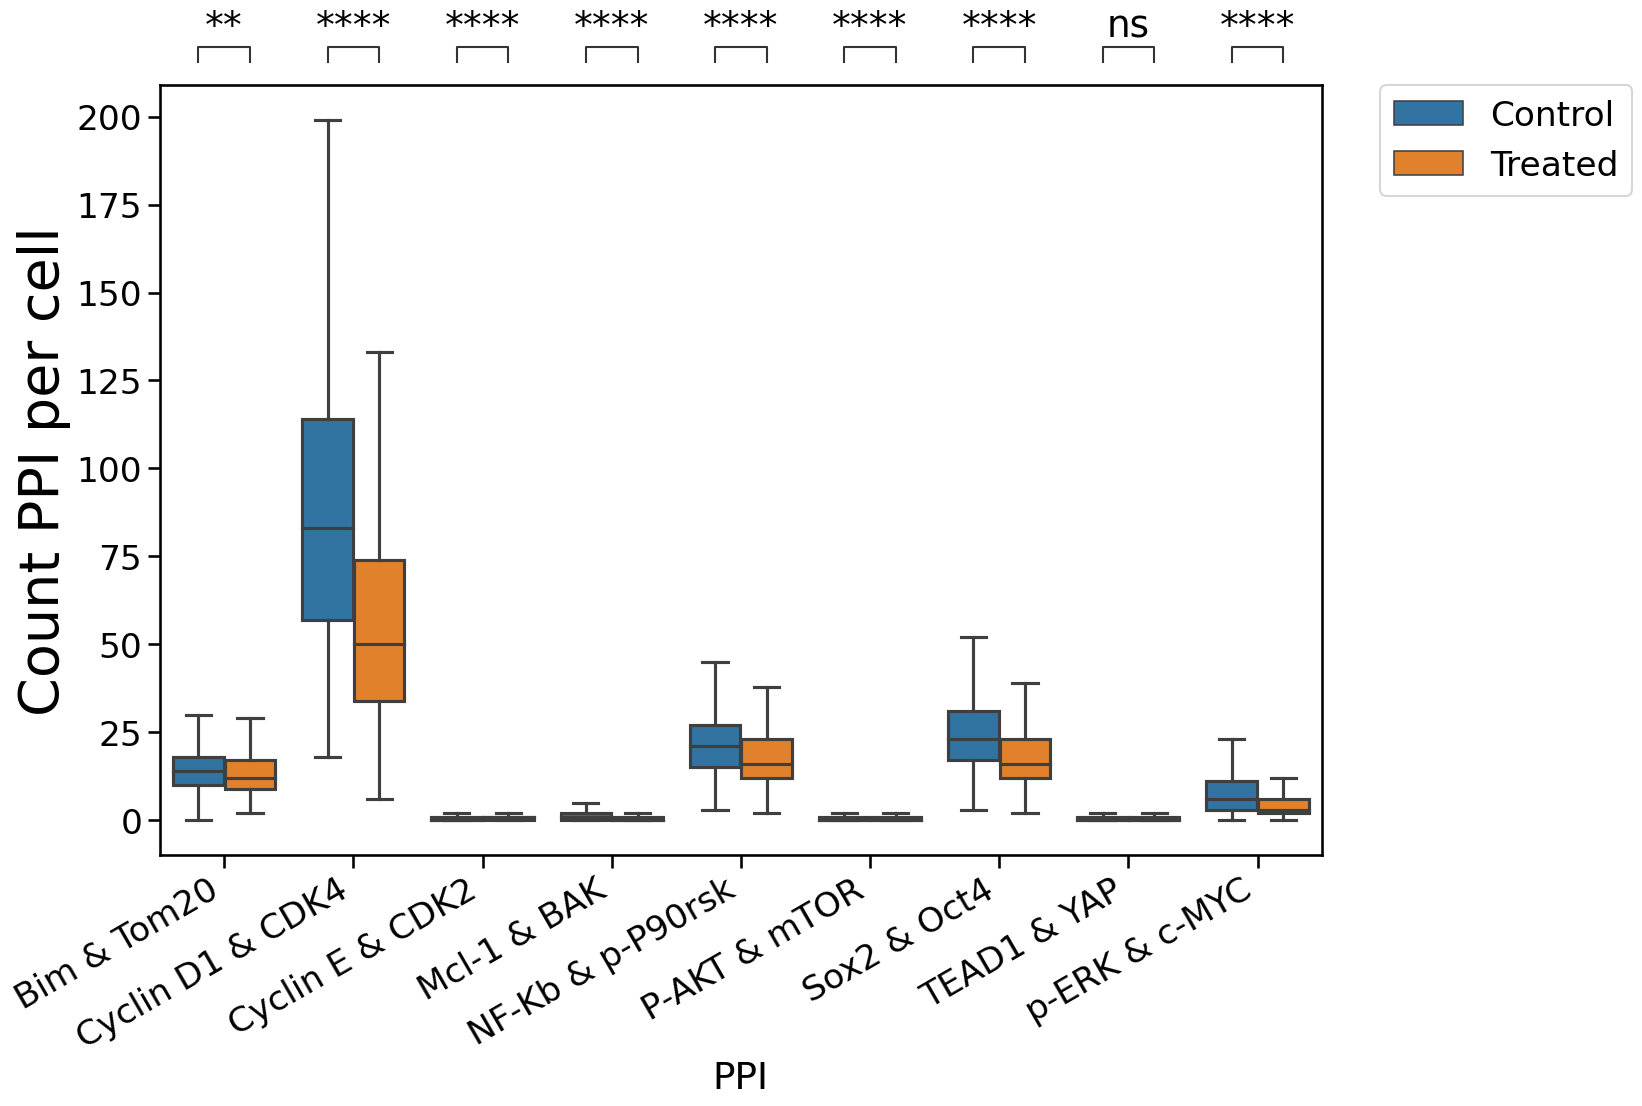

In [12]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_cell",
    "hue": "Condition",
    "hue_order": ['Control', 'Treated'],

}

plot(plotting)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-ERK & c-MYC_Control vs. p-ERK & c-MYC_Treated: Mann-Whitney-Wilcoxon test two-sided, P_val:1.340e-13 U_stat=3.182e+05
Cyclin D1 & CDK4_Control vs. Cyclin D1 & CDK4_Treated: Mann-Whitney-Wilcoxon test two-sided, P_val:1.143e-48 U_stat=3.774e+05
Bim & Tom20_Control vs. Bim & Tom20_Treated: Mann-Whitney-Wilcoxon test two-sided, P_val:2.401e-02 U_stat=2.788e+05
Cyclin E & CDK2_Control vs. Cyclin E & CDK2_Treated: Mann-Whitney-Wilcoxon test two-sided, P_val:3.364e-11 U_stat=2.247e+05
Mcl-1 & BAK_Control vs. Mcl-1 & BAK_Treated: Mann-Whitney-Wilcoxon test two-sided, P_val:2.457e-05 U_stat=2.857e+05
NF-Kb & p-P90rsk_Control vs. NF-Kb & p-P90rsk_Treated: Mann-Whitney-Wilcoxon test two-sided, P_val:2.603e-12 U_stat=3.164e+05
P-AKT & mTOR_Control vs. P-AKT & mTOR_Treated: Mann-Whitney-Wilcoxon test two-si

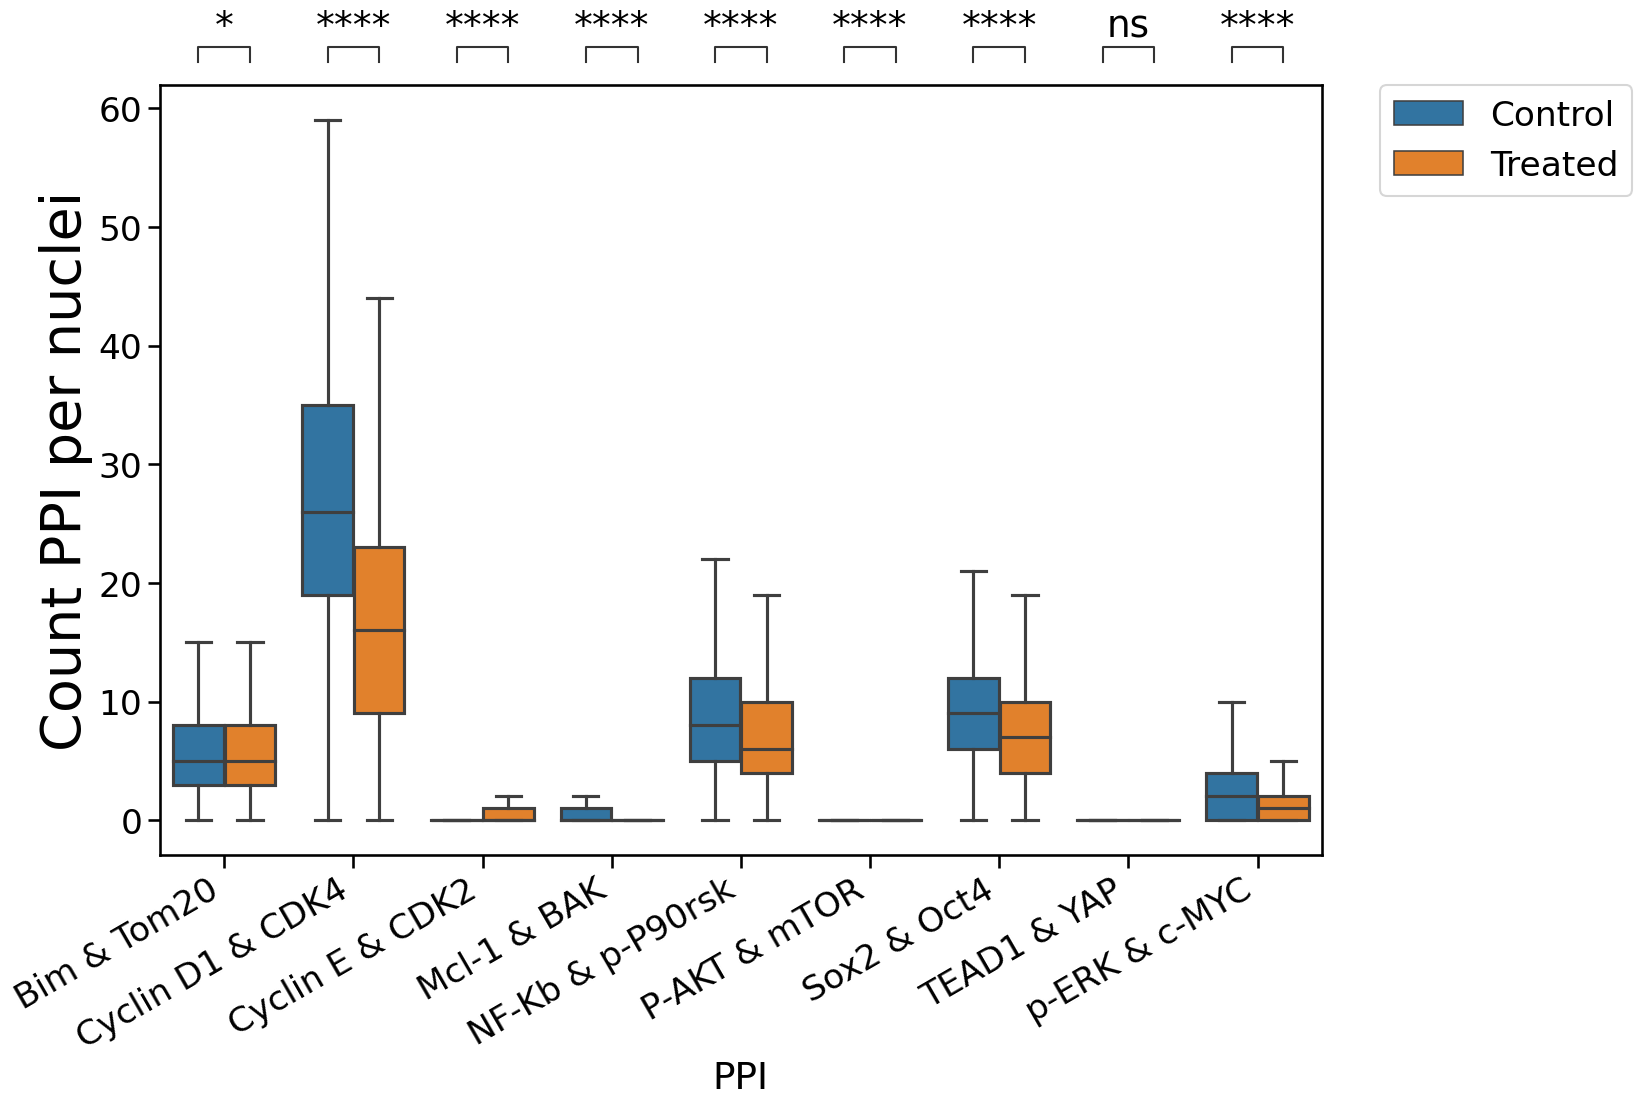

In [13]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_nuclei",
    "hue": "Condition",
    "hue_order": ['Control', 'Treated'],

}

plot(plotting, y_title='Count PPI per nuclei')

In [14]:
plotting['data'].groupby([plotting['hue'], plotting['x']])[plotting['y']].describe().to_clipboard()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-ERK & c-MYC_Control vs. p-ERK & c-MYC_Treated: Mann-Whitney-Wilcoxon test two-sided, P_val:6.400e-09 U_stat=3.063e+05
Cyclin D1 & CDK4_Control vs. Cyclin D1 & CDK4_Treated: Mann-Whitney-Wilcoxon test two-sided, P_val:9.073e-23 U_stat=3.390e+05
Bim & Tom20_Control vs. Bim & Tom20_Treated: Mann-Whitney-Wilcoxon test two-sided, P_val:2.914e-01 U_stat=2.693e+05
Cyclin E & CDK2_Control vs. Cyclin E & CDK2_Treated: Mann-Whitney-Wilcoxon test two-sided, P_val:3.362e-10 U_stat=2.213e+05
Mcl-1 & BAK_Control vs. Mcl-1 & BAK_Treated: Mann-Whitney-Wilcoxon test two-sided, P_val:2.826e-03 U_stat=2.812e+05
NF-Kb & p-P90rsk_Control vs. NF-Kb & p-P90rsk_Treated: Mann-Whitney-Wilcoxon test two-sided, P_val:4.330e-04 U_stat=2.888e+05
P-AKT & mTOR_Control vs. P-AKT & mTOR_Treated: Mann-Whitney-Wilcoxon test two-si

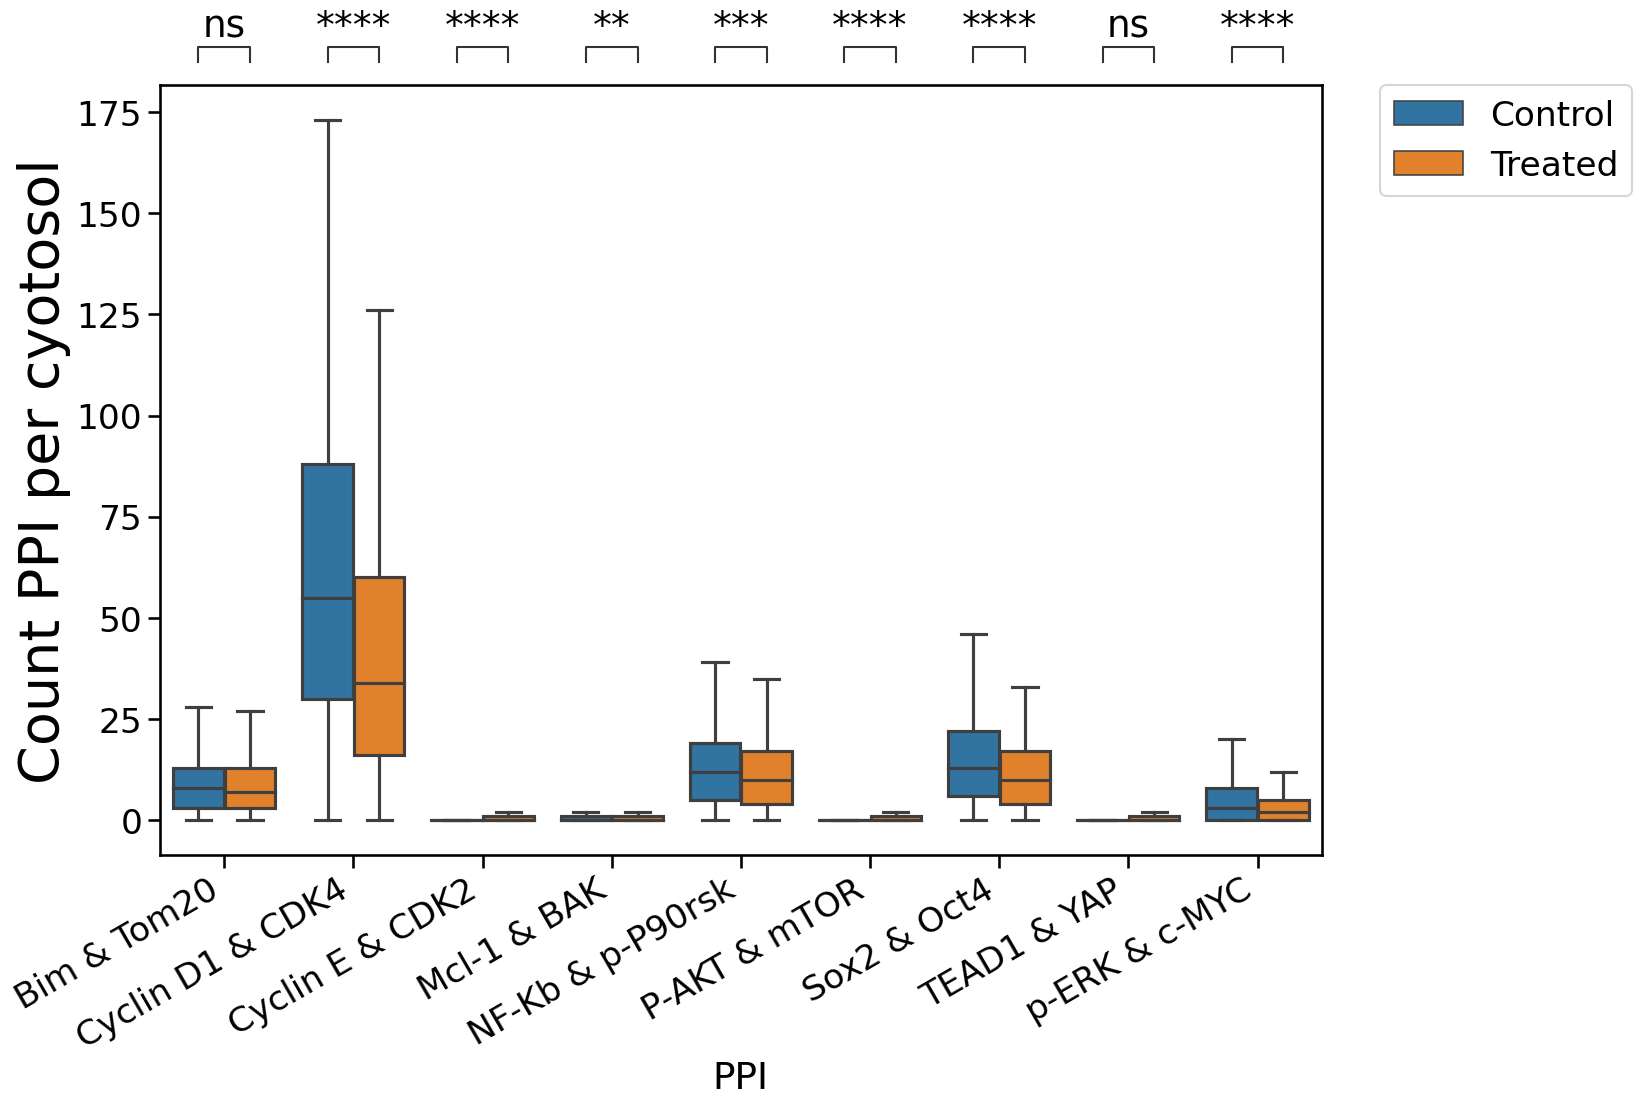

In [15]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_cyto",
    "hue": "Condition",
    "hue_order": ['Control', 'Treated'],

}

plot(plotting, y_title='Count PPI per cyotosol')

In [16]:
plotting['data'].groupby([plotting['hue'], plotting['x']])[plotting['y']].describe().to_clipboard()

## Statistics

In [15]:
df_combined = df_all.groupby(['Condition', 'FOV', 'Id'])[['Count_cell', 'Count_nuclei', 'Count_cyto']].agg('sum').reset_index()

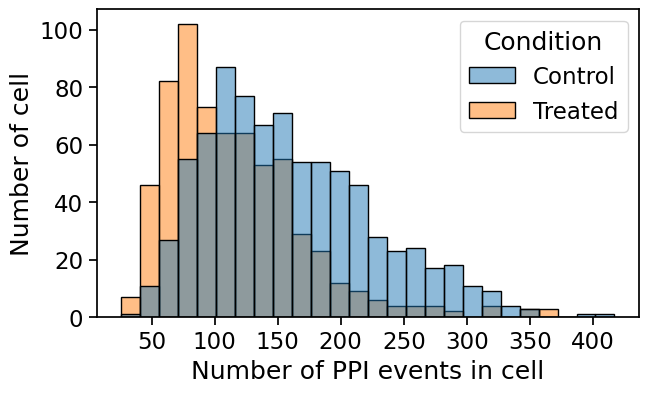

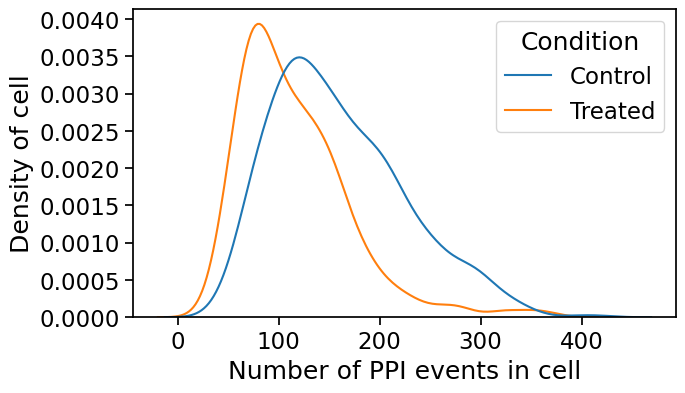

In [16]:
# Plot histo
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(figsize=(7,4))
    sns.histplot(data=df_combined, x='Count_cell', hue='Condition', ax=ax)
    ax.set_ylabel('Number of cell')
    ax.set_xlabel('Number of PPI events in cell')

# Plot kde
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(figsize=(7,4))
    sns.kdeplot(data=df_combined, x='Count_cell', hue='Condition', ax=ax)
    ax.set_ylabel('Density of cell')
    ax.set_xlabel('Number of PPI events in cell')    

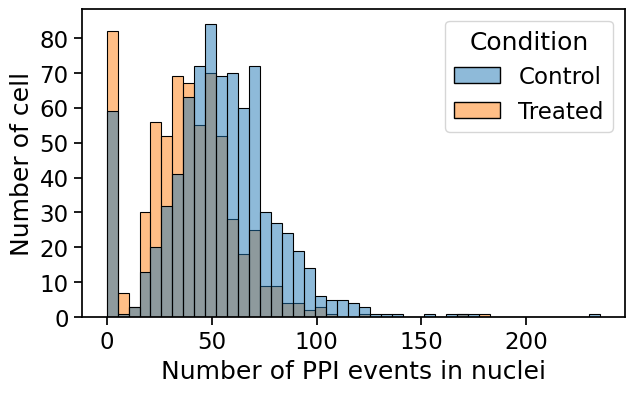

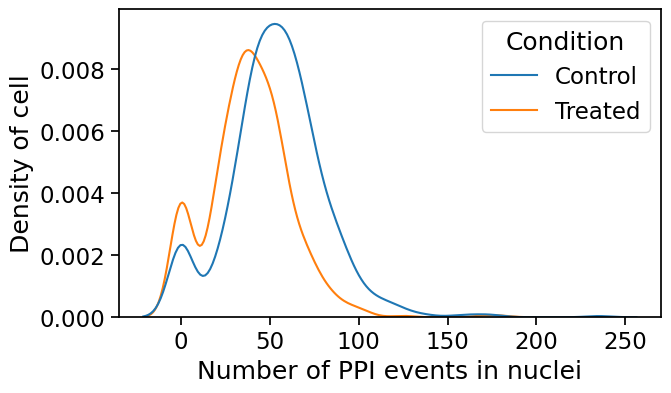

In [17]:
# Plot histo
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(figsize=(7,4))
    sns.histplot(data=df_combined, x='Count_nuclei', hue='Condition', ax=ax)
    ax.set_ylabel('Number of cell')
    ax.set_xlabel('Number of PPI events in nuclei')

# Plot kde
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(figsize=(7,4))
    sns.kdeplot(data=df_combined, x='Count_nuclei', hue='Condition', ax=ax)
    ax.set_ylabel('Density of cell')
    ax.set_xlabel('Number of PPI events in nuclei')    

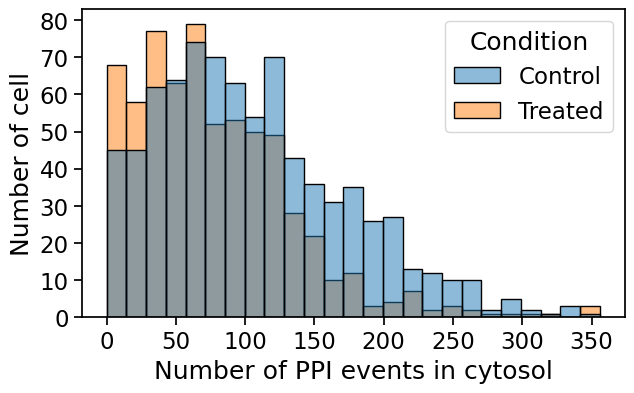

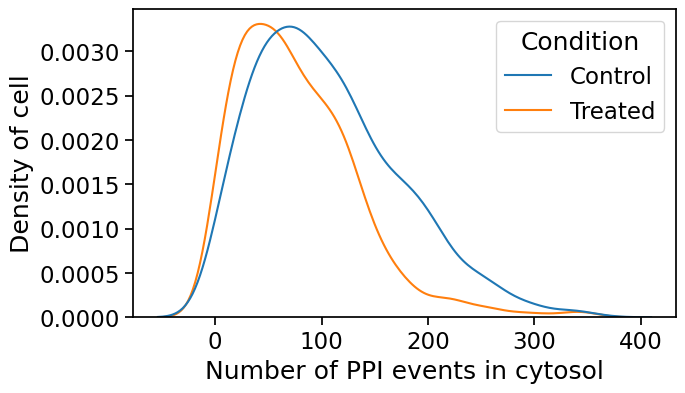

In [18]:
# Plot histo
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(figsize=(7,4))
    sns.histplot(data=df_combined, x='Count_cyto', hue='Condition', ax=ax)
    ax.set_ylabel('Number of cell')
    ax.set_xlabel('Number of PPI events in cytosol')

# Plot kde
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(figsize=(7,4))
    sns.kdeplot(data=df_combined, x='Count_cyto', hue='Condition', ax=ax)
    ax.set_ylabel('Density of cell')
    ax.set_xlabel('Number of PPI events in cytosol')    

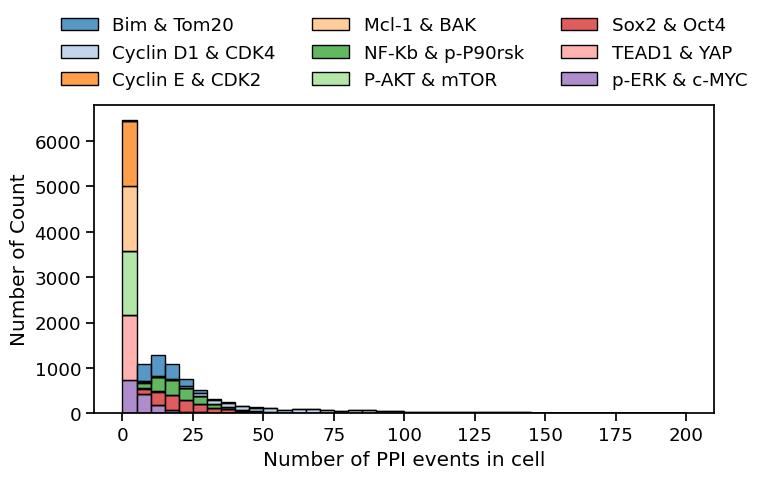

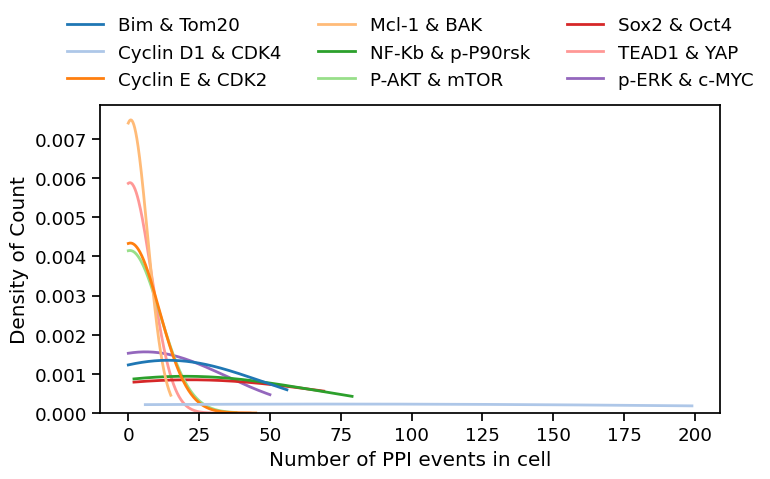

In [17]:
# Plot histo
with sns.plotting_context("notebook", font_scale=1.2):
    fig, ax = plt.subplots(figsize=(8,4))
    sns.histplot(data=df_all, x='Count_cell', hue='PPI', ax=ax, multiple="stack", palette='tab20', binwidth=5)
    ax.set_ylabel('Number of Count')
    ax.set_xlabel('Number of PPI events in cell')
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)


# Plot kde
with sns.plotting_context("notebook", font_scale=1.2):
    fig, ax = plt.subplots(figsize=(8,4))
    sns.kdeplot(data=df_all, x='Count_cell', hue='PPI', ax=ax, palette='tab20', cut=0, bw_adjust=20, lw=2)
    ax.set_ylabel('Density of Count')
    ax.set_xlabel('Number of PPI events in cell')    
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)

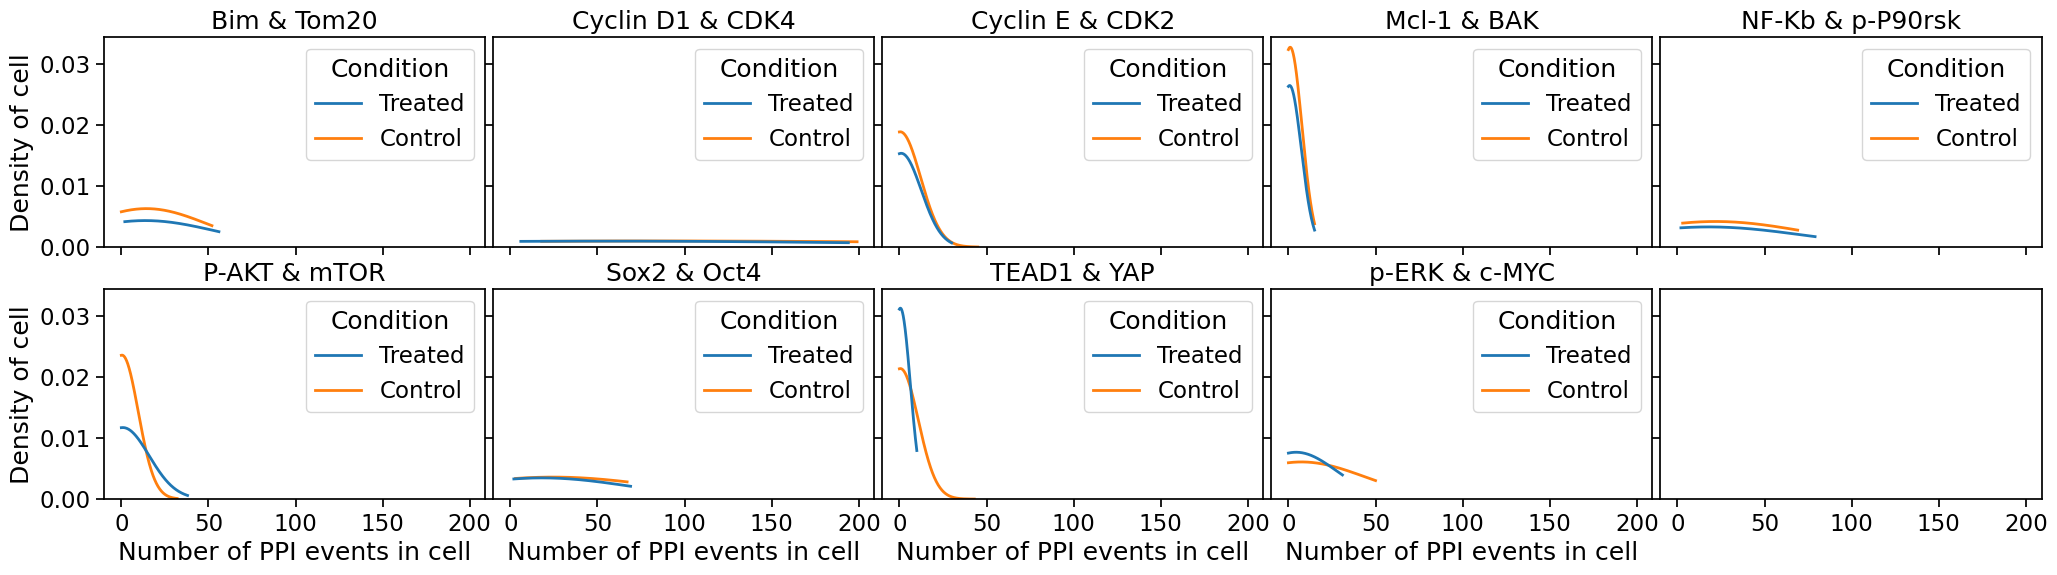

In [18]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, axs = plt.subplots(2, 5, figsize=(25,6), sharex=True, sharey=True)
    axs = axs.flatten()
    for i, PPI in enumerate(df_all.PPI.unique()):
        df_subset = df_all[df_all.PPI == PPI]
        # Plot kde
        sns.kdeplot(data=df_subset, x='Count_cell', hue='Condition', ax=axs[i], 
                    hue_order= ['Treated', 'Control'], cut=0, bw_adjust=20, lw=2)
        axs[i].set_title(PPI)
        axs[i].set_ylabel('Density of cell')
        axs[i].set_xlabel(f'Number of PPI events in cell')
    fig.subplots_adjust(wspace=0.02)
    plt.show()

# Co-expression histogram

## Extract Co-expression

In [19]:
from functools import partial

def read_mean_pixels(x, y, window_size, path):
    x_min = np.clip(x-window_size,a_min=0, a_max=None)
    x_max = x+window_size
    y_min = np.clip(y-window_size, a_min=0, a_max=None)
    y_max = y+window_size
    
    with h5py.File(path, "r") as f:
        pixels = f['imgs'][:, y_min:y_max, x_min:x_max]
    mean_expression = pixels.mean(axis=(1,2))
    return mean_expression
    
def extract(df, path, window_size=5):
    x = df['x'].to_numpy()
    y = df['y'].to_numpy()
    
    # Read markers name 
    with h5py.File(path, "r") as f:
        markers = f['imgs'].attrs['Marker']
    
    # Define partial and joblib
    read_partial = partial(read_mean_pixels, window_size=window_size, path=path)
    mean_expressions = Parallel(n_jobs=20)(delayed(read_partial)(i,j) for i,j in zip(y,x))
    
    # create dataframe
    _, indices = np.unique(markers, return_index=True)
    indices.sort()
    marker_unique = markers[indices]
    mean_expressions = np.stack(mean_expressions)
    df_exp = pd.DataFrame(mean_expressions[:, indices], columns=marker_unique)
    return df_exp

In [20]:
# Read PPI
PPI_save_path =  data_dir / '9PPI' / 'PPI'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)
df.reset_index(inplace=True, drop=True)
df_fil = df[df.Cyto > 0]

In [21]:
df_imgs

,Timepoint,FOV,Path
0,HCC827Ctrl,FW1,Y:\coskun-lab\Thomas\15_PLA\data\9PPI Cell Cul...
1,HCC827Ctrl,FW2,Y:\coskun-lab\Thomas\15_PLA\data\9PPI Cell Cul...
2,HCC827Osim,FW1,Y:\coskun-lab\Thomas\15_PLA\data\9PPI Cell Cul...
3,HCC827Osim,FW2,Y:\coskun-lab\Thomas\15_PLA\data\9PPI Cell Cul...


In [22]:
# Get Co-expression data
PPI_exp_path =  data_dir / '9PPI' / 'PPI' / 'expression'
PPI_exp_path.mkdir(parents=True, exist_ok=True)

group = df_fil.groupby(['Condition', 'FOV'])

for name, df_group in group:
    path = df_imgs[(df_imgs.Timepoint == name[0]) & (df_imgs.FOV == name[1])].Path.item()
    df_expression = extract(df_group, path)
    
    df_merged = pd.concat([df_group.reset_index().rename({'index':'Original Index'}, axis=1), 
                           df_expression], axis=1)
    
    # Save coexpression
    file_name = '_'.join(name)
    save_path = PPI_exp_path / f'{file_name}.csv'
    df_merged.to_csv(save_path)

KeyboardInterrupt: 

## Quantification

In [23]:
# Get Co-expression data
PPI_save_path =  data_dir / '9PPI' / 'PPI' / 'expression'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path, index_col=0)
        dfs.append(df)

df_exp = pd.concat(dfs)

In [24]:
# Check for general trend y converting to adata and groupby by Condition
df_obs = df_exp.iloc[:, :9]
df_marker_exp = df_exp.iloc[:, 9:]
df_norm = (df_marker_exp-df_marker_exp.min())/(df_marker_exp.max()-df_marker_exp.min())
# df_norm = (df_marker_exp - df_marker_exp.mean())/df_marker_exp.std()
# df_norm = (df_marker_exp-df_marker_exp.quantile(0.05))/(df_marker_exp.quantile(0.95)-df_marker_exp.quantile(0.05))
df_norm = df_norm.clip(lower=0, upper=1)
df_exp.iloc[:, 9:] = df_norm

In [25]:
import anndata as ad
import scanpy as sc
sc.set_figure_params(transparent=True)

adata = ad.AnnData(df_marker_exp.values, dtype=df_norm.values.dtype)
adata.var_names = df_marker_exp.columns.tolist()
adata.obs = df_obs
adata.obs['PPI'] = adata.obs['PPI'].astype('category')
adata.obs['Condition'] = adata.obs['Condition'].astype('category')

# sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=4)
sc.tl.dendrogram(adata, groupby='PPI')

c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [29]:
df = pd.DataFrame(adata.X, columns=adata.var_names.tolist())
df['PPI'] = adata.obs['PPI'].tolist()
df['Condition'] = adata.obs['Condition'].tolist()

# Some renaming
rename_dict = {'HCC827Ctrl': 'Control', 'HCC827Osim': 'Treated'}
df['Condition'] = df['Condition'].apply(lambda x: rename_dict.get(x,x))

In [30]:

protein_markers2 = ['p-EGFR', 'Ki67', 'NBD-C6', 'COX IV', 'Pan-cytokeratin']

In [31]:
df.head()

,Hoeschst,Cyclin D1 & CDK2,NF-Kb & p-P90rsk,Sox2 & Oct4,Bim & Tom20,Mcl-1 & BAK,p-ERK & c-MYC,TEAD1 & YAP,Cyclin E & CDK4,P-AKT & mTOR,...,Cyclin D1 & CDK2 - re,NF-Kb & p-P90rsk - re,NBD-C6,Golph4,COX IV,Pan-cytokeratin,Concanavalin A,WGA,PPI,Condition
0,-0.012004,1.303757,-0.843181,-0.844166,-0.870700,-0.381619,-0.456626,-0.515304,-0.474530,-0.531252,...,-0.564135,-0.611326,-0.977999,-0.811847,-0.534311,0.148927,-0.828024,-0.460319,Cyclin D1 & CDK2,Control
1,1.280145,2.840310,0.810361,3.171514,0.273821,0.404992,0.383415,0.452226,0.277556,0.388693,...,0.933843,1.415506,-0.195075,-1.086820,0.696835,-0.631349,0.344000,1.284275,Cyclin D1 & CDK2,Control
2,-0.507734,1.491168,2.412028,-0.683420,-0.289497,0.301704,0.135001,-0.015983,-0.056871,0.149142,...,-0.239978,-0.127830,-0.494963,-0.836211,-0.231130,0.375086,-0.836446,0.186072,Cyclin D1 & CDK2,Control
3,0.322148,4.000000,-0.323126,2.115124,-0.307948,0.144973,-0.101920,-0.082492,-0.145950,0.008402,...,-0.329592,-0.115198,-0.621431,-0.811845,-0.186314,0.246984,-0.413496,-0.232606,Cyclin D1 & CDK2,Control
4,-0.797428,2.876515,-0.315345,-0.894827,-0.737964,-0.334086,-0.383984,-0.605481,-0.543579,0.032734,...,-0.231420,-0.148533,0.846750,-0.794256,0.261149,-0.327105,1.091397,1.105462,Cyclin D1 & CDK2,Control


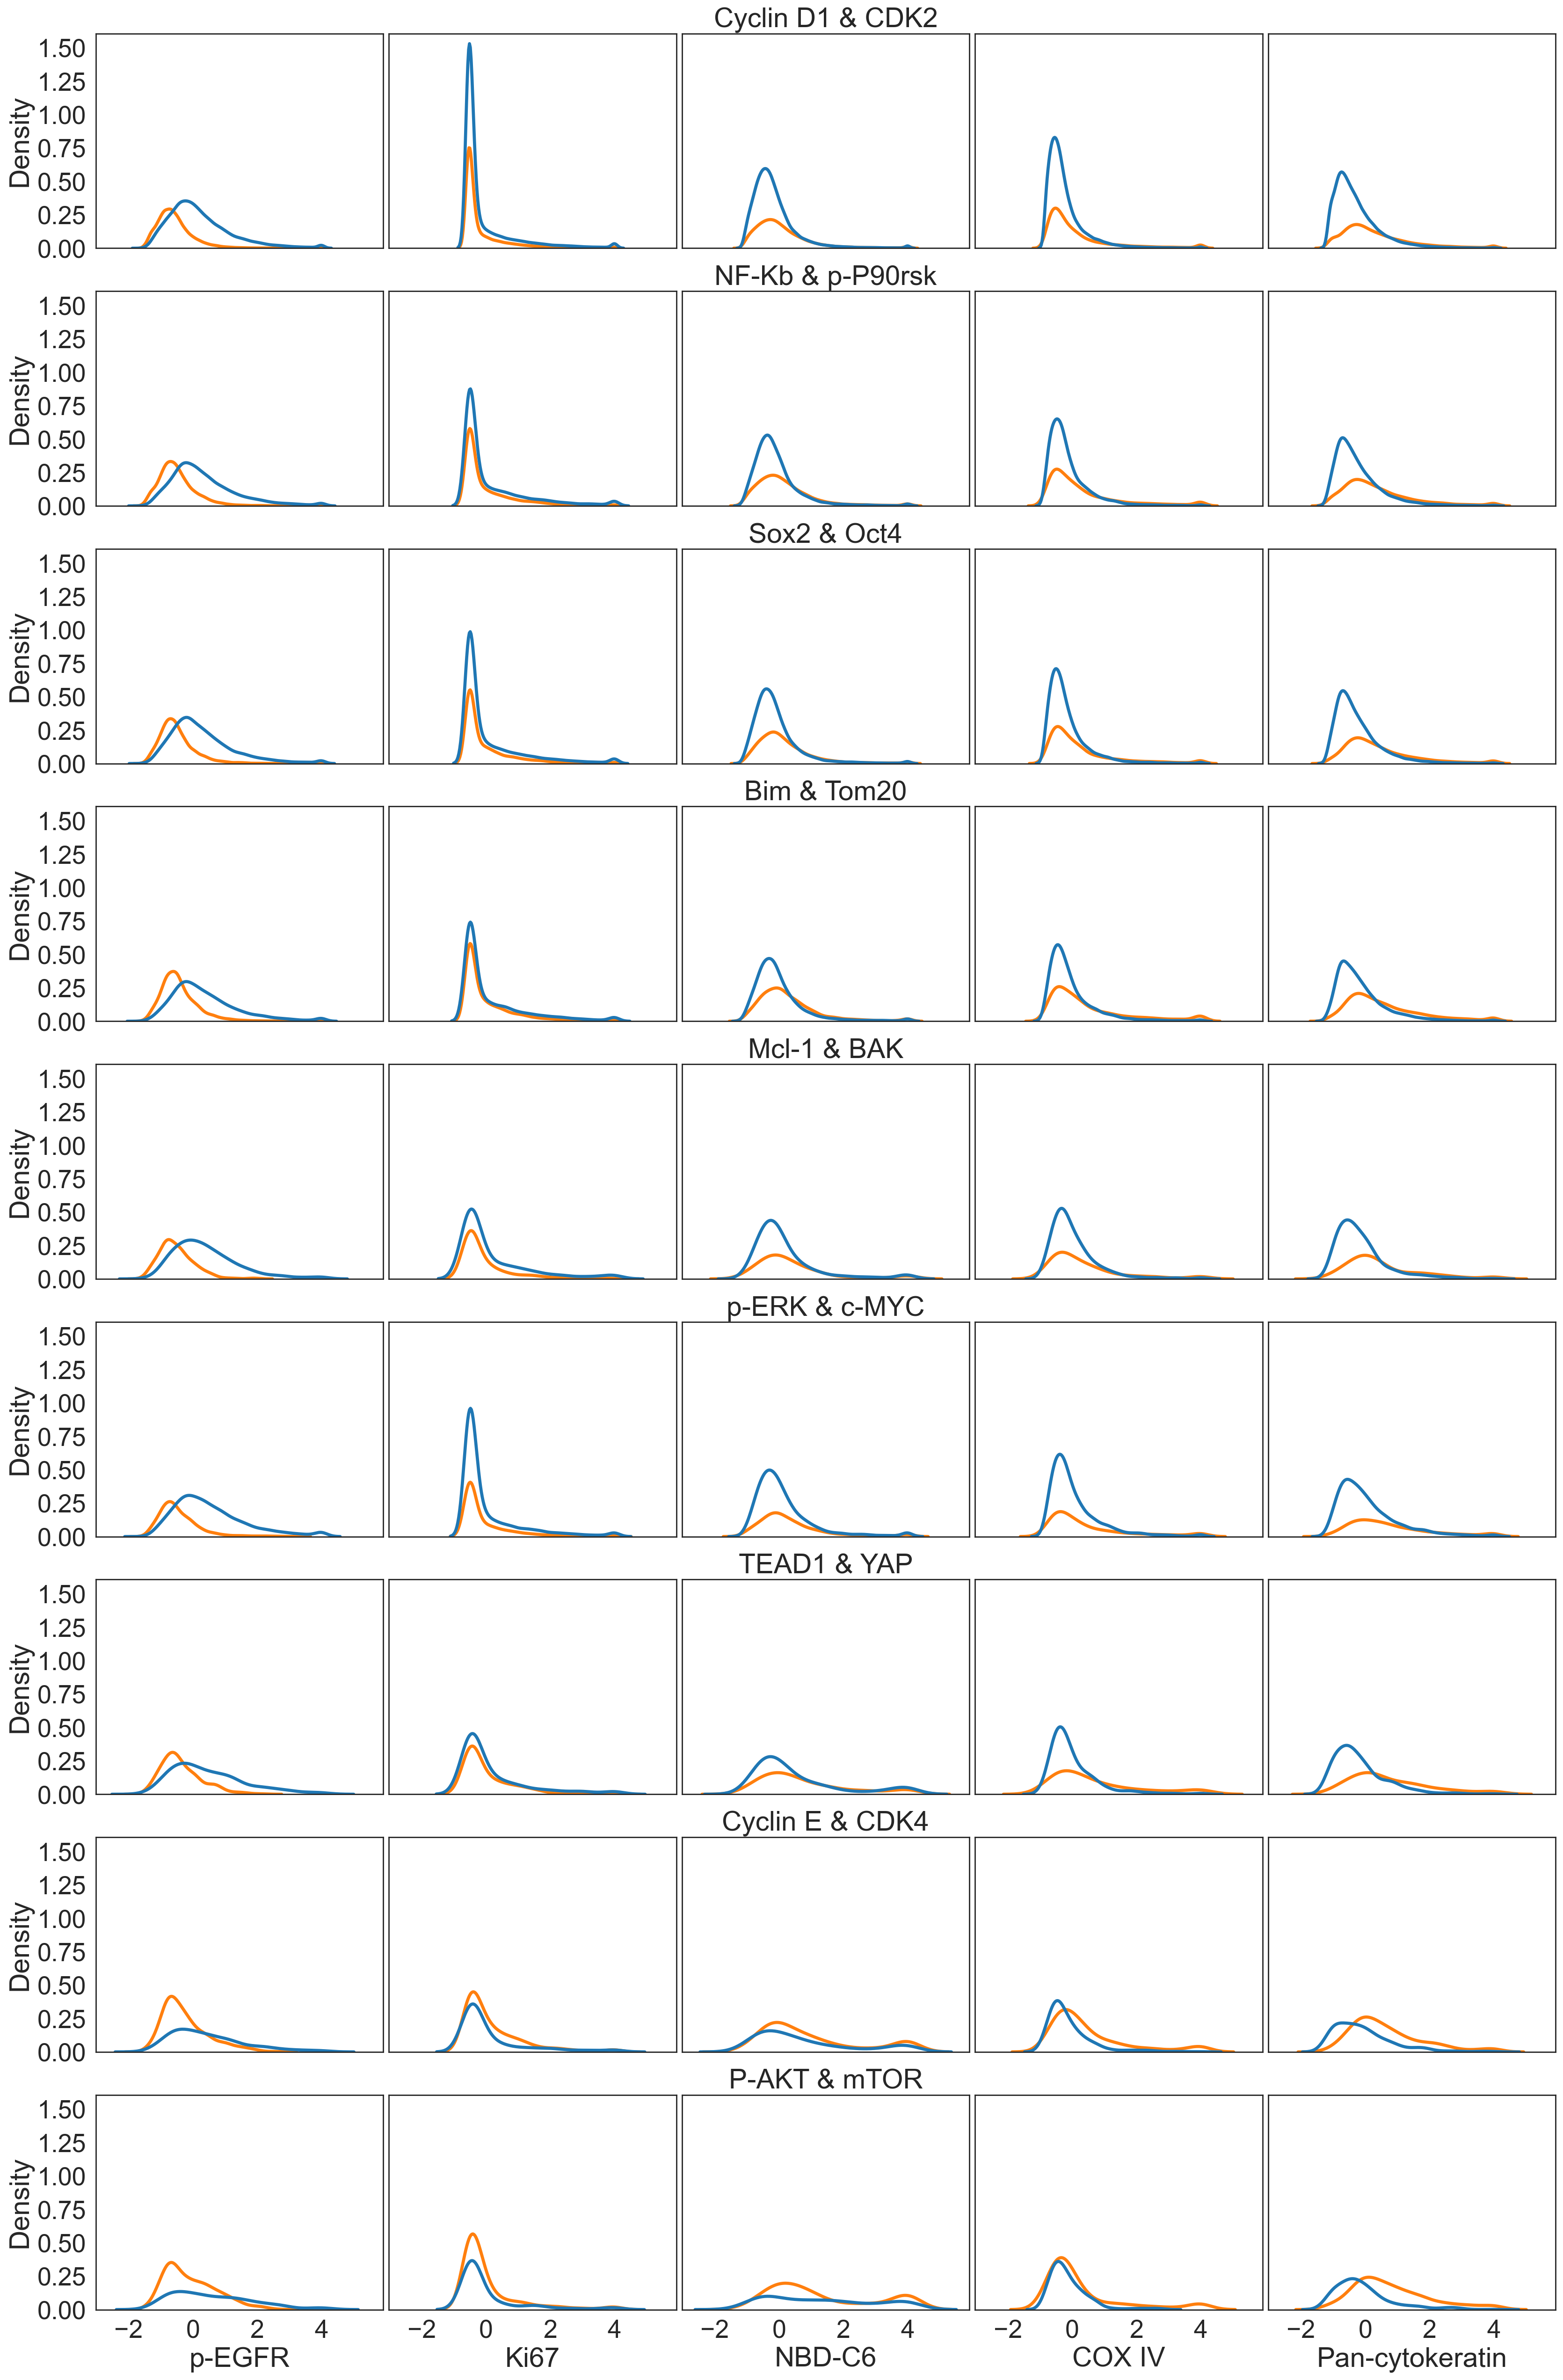

In [34]:
sns.set_style("white")

with sns.plotting_context("notebook", font_scale=2.2):
    fig, axs = plt.subplots(9, len(protein_markers2), figsize=(25,40), sharey=True, sharex=True)
    for i, PPI in enumerate(df.PPI.unique()[:-2]):
        df_subset = df[df.PPI == PPI][['Condition'] + protein_markers2].reset_index(drop=True)
        # Plot kde
        for j, marker in enumerate(protein_markers2):
            g = sns.kdeplot(data=df_subset, x=marker, hue='Condition', ax=axs[i, j], bw_adjust=1, lw=3)
            axs[i,j].get_legend().set_visible(False)
        axs[i,2].set_title(PPI)
    fig.subplots_adjust(wspace=0.02)

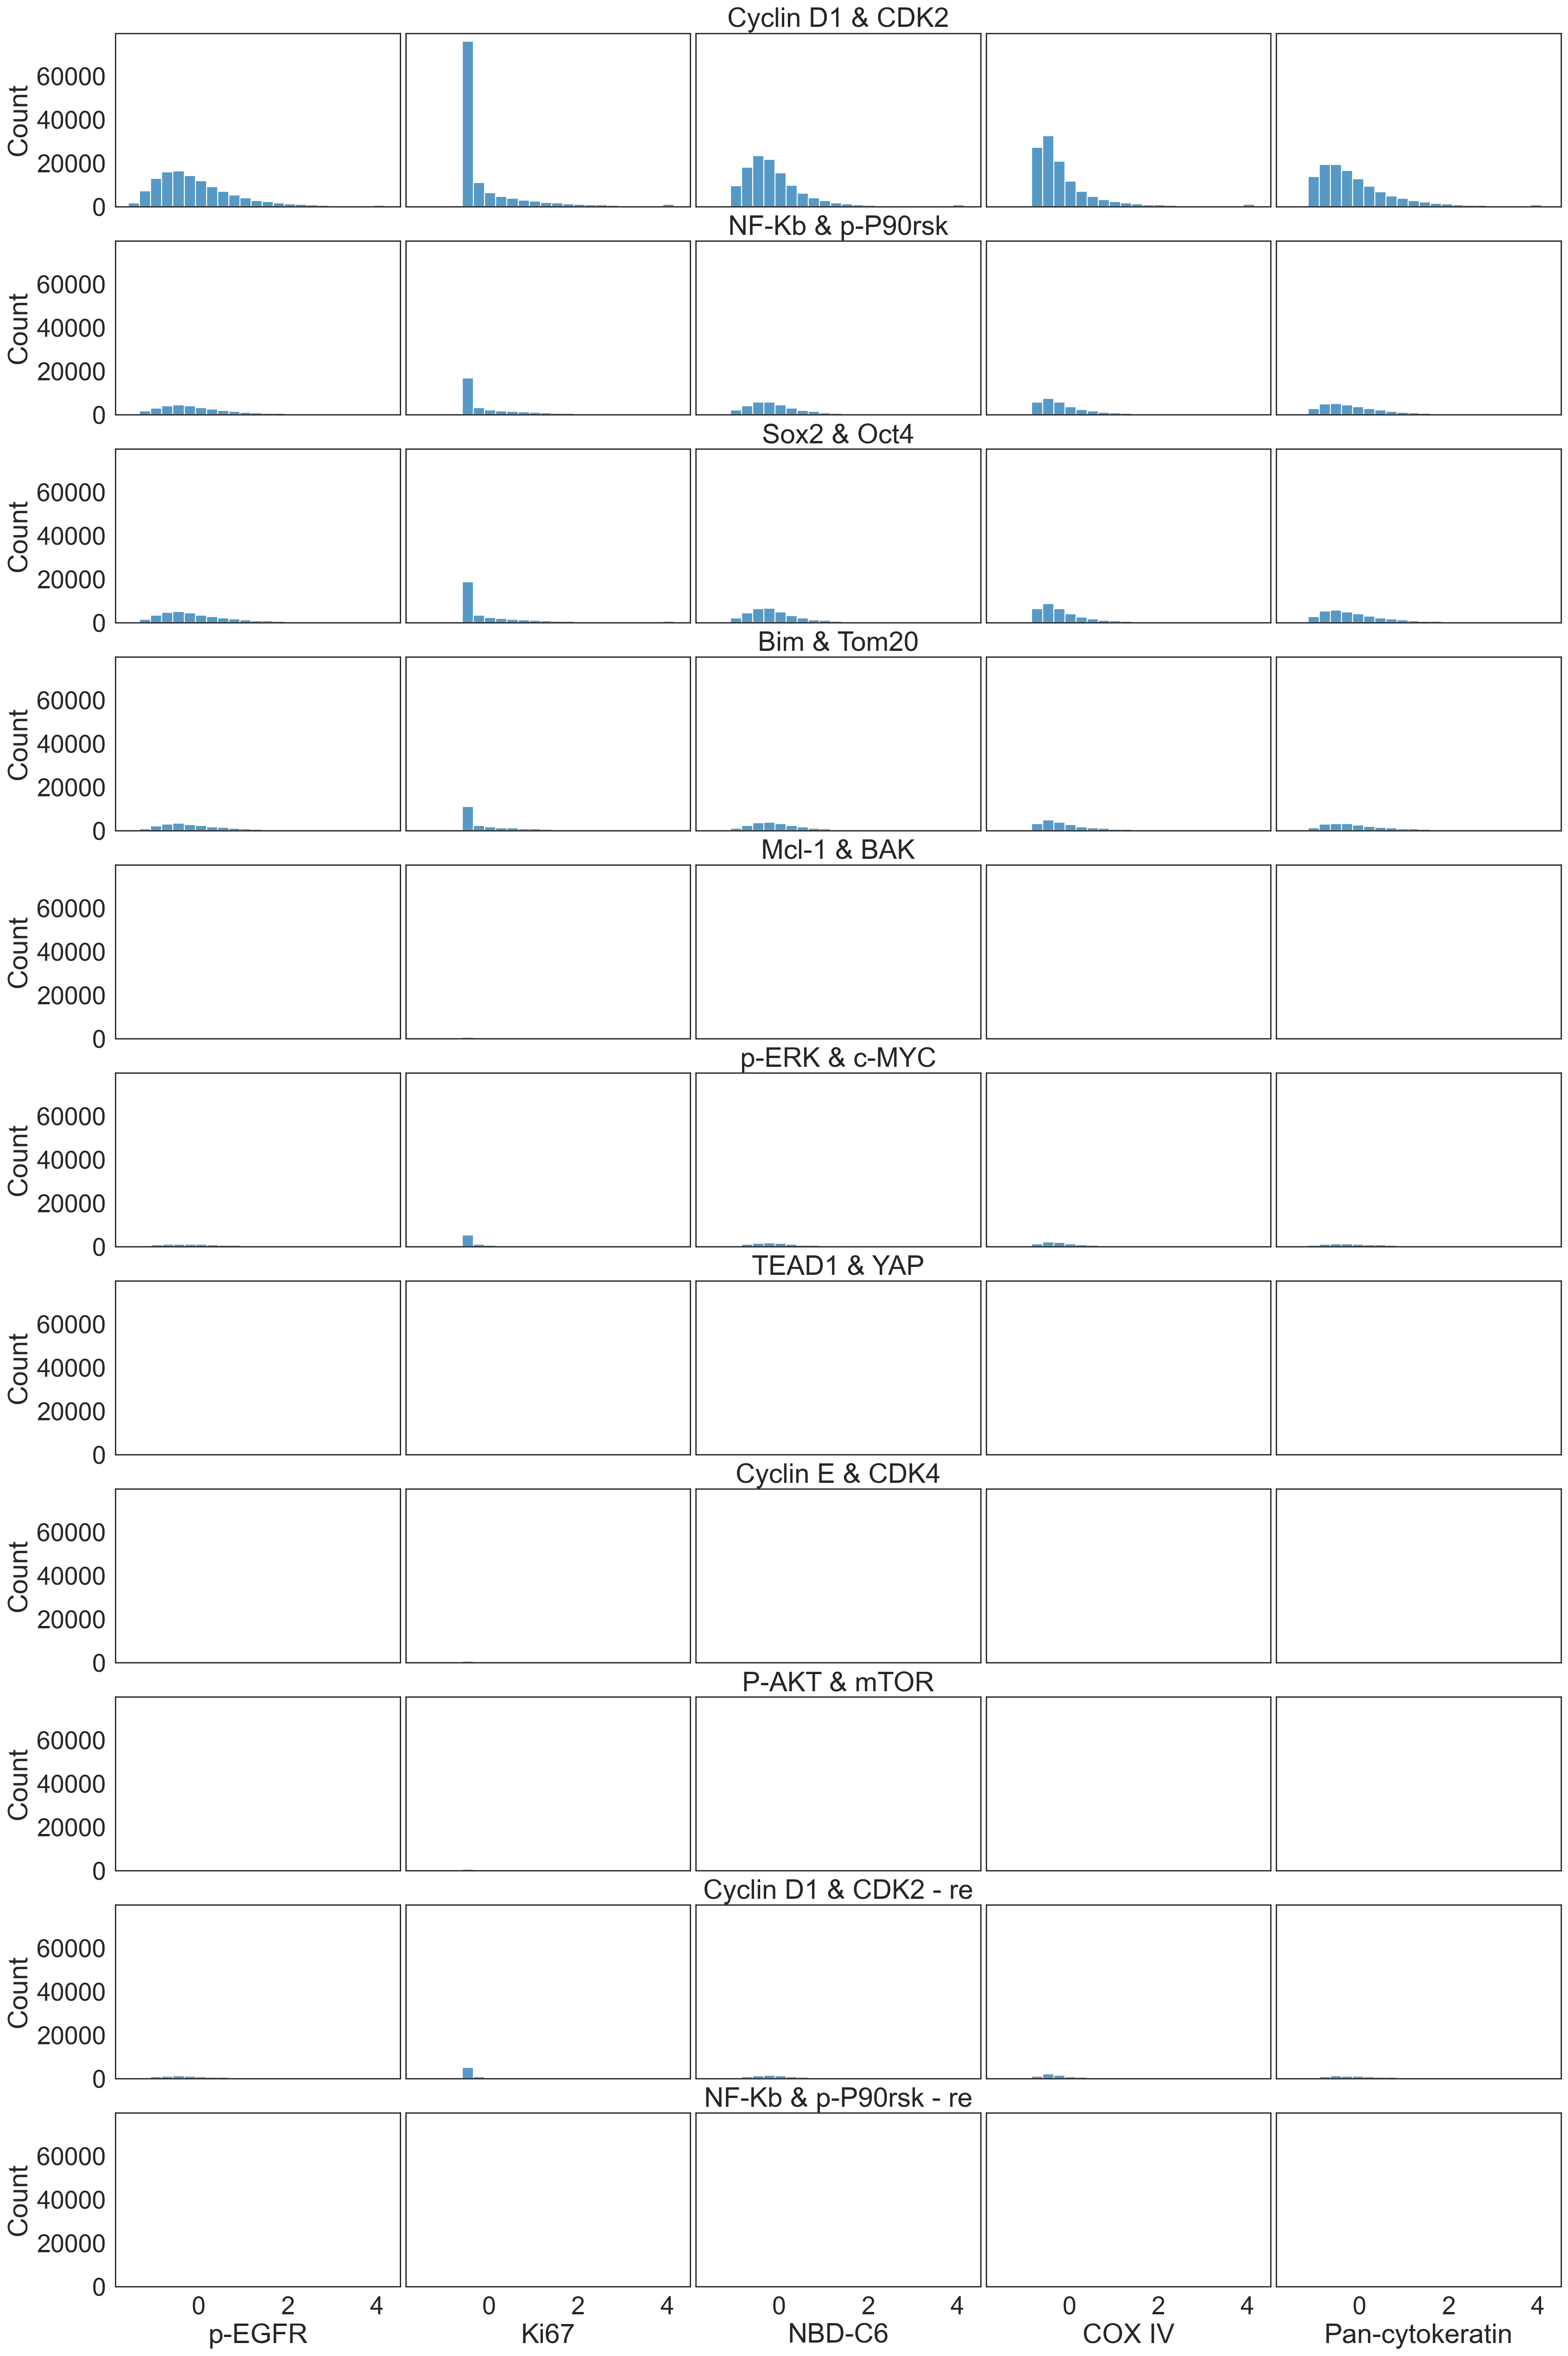

In [ ]:
sns.set_style("white")

with sns.plotting_context("notebook", font_scale=2.2):
    fig, axs = plt.subplots(11, len(protein_markers2), figsize=(25,40), sharey=True, sharex=True)
    for i, PPI in enumerate(df.PPI.unique()):
        df_subset = df[df.PPI == PPI][['Condition'] + protein_markers2].reset_index(drop=True)
        # Plot kde
        for j, marker in enumerate(protein_markers2):
            g = sns.histplot(data=df_subset, x=marker, ax=axs[i, j],binwidth=0.25,)

        axs[i,2].set_title(PPI)
    fig.subplots_adjust(wspace=0.02)